In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jieba.posseg as pseg
import keras
import numpy as np
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.model_selection import train_test_split


In [15]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [16]:
train = pd.read_csv("/content/gdrive/My Drive/space_Colab/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/space_Colab/test.csv")

In [7]:
train.info()
train.describe(include ='all' )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320552 entries, 0 to 320551
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         320552 non-null  int64 
 1   tid1       320552 non-null  int64 
 2   tid2       320552 non-null  int64 
 3   title1_zh  320552 non-null  object
 4   title2_zh  320545 non-null  object
 5   title1_en  320552 non-null  object
 6   title2_en  320552 non-null  object
 7   label      320552 non-null  object
dtypes: int64(3), object(5)
memory usage: 19.6+ MB


,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
count,320552.000000,320552.000000,320552.000000,320552,320545,320552,320552,320552
unique,NaN,NaN,NaN,69170,138434,67869,136111,3
top,NaN,NaN,NaN,岑溪市人民医院有人跳楼身亡,白发不用着急，在家就能用的小妙招吧，白发7天变黑发告别染发,Someone from the People's Hospital of Cengxi C...,The world's first talking dog shocked 6 billio...,unrelated
freq,NaN,NaN,NaN,755,16,755,66,219313
mean,160626.632930,85051.949656,69729.488944,NaN,NaN,NaN,NaN,NaN
std,92727.810352,48400.120470,45484.649036,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN
25%,80356.750000,44041.000000,30636.000000,NaN,NaN,NaN,NaN,NaN
50%,160639.500000,85416.000000,63766.500000,NaN,NaN,NaN,NaN,NaN
75%,240967.250000,127476.000000,105289.500000,NaN,NaN,NaN,NaN,NaN


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80126 entries, 0 to 80125
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         80126 non-null  int64 
 1   tid1       80126 non-null  int64 
 2   tid2       80126 non-null  int64 
 3   title1_zh  80126 non-null  object
 4   title2_zh  80125 non-null  object
 5   title1_en  80126 non-null  object
 6   title2_en  80126 non-null  object
dtypes: int64(3), object(4)
memory usage: 4.3+ MB


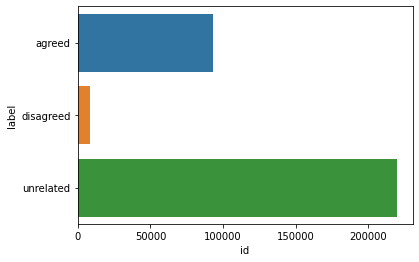

In [9]:
data =  train.groupby('label')['id'].count()
sns.barplot(data,data.index)

<font color = '#0000FF'>1. 分詞


In [21]:
def jeiba_tokenizer(text):
    words = pseg.cut(text)
    return [' '.join(word) for word, flag in words if flag != 'x']


In [18]:
train['title2_zh'] = train['title2_zh'].astype('str')

In [22]:
train['title1_tokenized'] = train.loc[:,'title1_zh'].apply(jeiba_tokenizer)
train['title2_tokenized'] = train.loc[:,'title2_zh'].apply(jeiba_tokenizer)


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.717 seconds.
Prefix dict has been built successfully.


<font color = '#0000FF'>2. 建立字典

In [25]:
MAX_NUM_WORDS = 10000
tokenizer =keras.preprocessing.text.Tokenizer(num_words = MAX_NUM_WORDS)

In [26]:
corpus_x1 = train.title1_tokenized
corpus_x2 = train.title2_tokenized
corpus = pd.concat([corpus_x1,corpus_x2])
corpus.shape

(641104,)

In [27]:
tokenizer.fit_on_texts(corpus)

<font color = '#0000FF'>3. 利用字典訓練後的tokenizer將文字轉換成數字序列

In [28]:
x1_train = tokenizer.texts_to_sequences(corpus_x1)
x2_train = tokenizer.texts_to_sequences(corpus_x2)

In [29]:
x1_train[0]

[218, 1268, 32, 1178, 5971, 24, 489, 2876, 116, 5563, 4, 1848, 2, 13]

In [30]:
# 數字序列轉換為文字
for seq in x1_train[:1]:
  print([tokenizer.index_word[idx] for idx in seq])

['2 0 1 7', '养 老 保 险', '又', '新 增', '两 项', '农 村', '老 人', '人 人', '可', '申 领', '你', '领 到', '了', '吗']


<font color = '#0000FF'>4. Zero Padding(每篇序列長度不同：補0對齊，或刪除後方多的)

In [ ]:
MAX_SEQUENCE_LENGTH = 20
x1_train = keras.preprocessing.sequence.pad_sequences(x1_train,maxlen=MAX_NUM_WORDS)
x2_train = keras.preprocessing.sequence.pad_sequences(x2_train,maxlen=MAX_NUM_WORDS)

5.Label進行 OHE<br>
OHE無法直接對字串進行編碼，需先透過LABEL ENCODING

In [ ]:
label_to_index = {'unrelated':0,'agreed':1,'disagreed':2}

# y_train = train.label.apply(lambda x : label_to_index[x])
y_train = train.label.map(label_to_index)
# keras的OHE要轉成array
# y_train = np.asarray(y_train).astype('float32')

In [ ]:
# y_train = keras.utils.to_categorical(y_train)
ohe = OHE()
y_train2 = ohe.fit_transform(y_train)

6.Train Test Split

In [ ]:
validation_ratio = 0.1
random_state = 9527

x1_train,x1_val,x2_train,x2_val,y_train,y_val = train_test_split(
    x1_train,x2_train,y_train,test_size = validation_ratio,random_state = random_state)

7.Train model

In [1]:
# rnn = laters.SimpleRNN()
lstm = layers.LSTM()

NameError: ignored

<font color = '#0000FF'>8. Word Embedding

將數字序列轉換成詞向量，RNN才能訓練<br>
詞向量的涵義：包含了遠近關係<br>
只要隨機初始化化詞向量，藉由反向傳播自動學習即可

In [ ]:
embedding_layer = layers.Embedding(MAX_NUM_WORDS,)

In [ ]:
num_classes = 3
max_num_words =10000
max_sequence_length = 20
num_embedding_dim = 256 #通常是128, 256, 512...
num_lstm_units = 128  #輸出的向量維度